###### From Josh Willis, 04 Mar 2024

In [1]:
import numpy as np
import os, glob
import netCDF4 as nc
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import time
import sys
from pathlib import Path 
from pyresample import kd_tree, geometry, utils
import xarray as xr

In [2]:
# input directory name for alongtrack
at_file_dir = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/')
at_file_dir_randomnoise = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/')
at_file_dir_missingdata = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_missingdata_nosicapplied/')
at_file_dir_orbiterror_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/')
at_file_dir_3errors_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/')
at_file_dir_beckley = Path('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/')

# output directory name for grids
grids_file_dir = Path('/home/jpluser/ECCO_GMSL/Data/gridding_output_nosicapplied/')
grids_file_dir_randomnoise = Path('/home/jpluser/ECCO_GMSL/Data/gridding_output_randomnoise_nosicapplied/')
grids_file_dir_missingdata = Path('/home/jpluser/ECCO_GMSL/Data/gridding_output_missingdata_nosicapplied/')
grids_file_dir_orbiterror_2cm = Path('/home/jpluser/ECCO_GMSL/Data/gridding_output_orbiterror_2cm_nosicapplied/')
grids_file_dir_3errors_2cm = Path('/home/jpluser/ECCO_GMSL/Data/gridding_output_3errors_2cm_nosicapplied/')
grids_file_dir_beckley = Path('/home/jpluser/ECCO_GMSL/Data/gridding_output_Beckley_dailyfiles/')

# other directories
main_dir = Path('/home/jpluser/ECCO_GMSL/')
data_dir = Path('/home/jpluser/ECCO_GMSL/Data/')

In [3]:
# Parameter definition
roi=600e3
sig=100e3
nb=500

# Basin Mask

In [4]:
# load the basin mask for the grid we are using
nf=nc.Dataset(os.path.join(data_dir, 'new_basin_mask.nc'),'r')
longrid=np.array(nf['lon'])
latgrid=np.array(nf['lat'])
bmask=np.array(nf['basinmask'])
longrid=longrid[1:-1:3]
latgrid=latgrid[1:-1:3]
bmask=bmask[1:-1:3,1:-1:3]
nf.close()

# change longitudes to +/- 180
ind=np.where(longrid>180)
ind1=np.where(longrid<=180)
longrid[ind] = longrid[ind]-360
longrid=np.hstack((longrid[ind],longrid[ind1]))
bmask=np.hstack((bmask[:,ind].squeeze(),bmask[:,ind1].squeeze()))

LOgrid,LAgrid=np.meshgrid(longrid,latgrid)

In [5]:
# make a "grid" for this basin mask grid
bmask_grid_def = geometry.GridDefinition(lons=LOgrid, lats=LAgrid)

In [6]:
# read in connection table 
# this tells us which basin numbers are connected
file=open(os.path.join(data_dir, 'basin_connection_table.txt'),'r')
lines=file.read().splitlines()
fid=np.zeros(len(lines),dtype='int16')
flist=[]
for i in range(len(fid)):
    fid[i]=np.int16(lines[i].split(':')[0])
    flist.append(np.int16(lines[i].split(':')[1].split(',')))
file.close() 

# Make grids from Beckley along track data daily files

In [7]:
# get filenames in that directory
files = sorted(glob.glob(os.path.join(at_file_dir_beckley, '*.h5')))
files[0]

'/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/MERGED_ALT-alt_ssh19920925.h5'

In [8]:
# initialize arrays
lon=np.zeros(0)
lat=np.zeros(0)
ssh=np.zeros(0,dtype='float64')
ddate=np.zeros(0,dtype='float64')

# load along-track data into arrays for the 10 first days
for i in range(10):
    nf=nc.Dataset(files[i],'r')
    nch = nf.groups.get('data')
    xds = xr.open_dataset(xr.backends.NetCDF4DataStore(nch))
                    
    # make "running" arrays, keep several days of data loaded at once
    lon=np.concatenate((lon,np.array(xds['lons'][:])))
    lat=np.concatenate((lat,np.array(xds['lats'][:])))
    ssh=np.concatenate((ssh,np.array(xds['ssh_smoothed'][:])))
    ddate=np.concatenate((ddate,np.float64(np.array(xds['time'][:]))))
            
    nf.close()

# change longitudes to +/- 180
ii=np.where(lon>180)
lon[ii]=lon[ii]-360

In [9]:
# create bflag that tells us which basin is in each ssh alongtrack (interpolation of swath on basin grid)
lon,lat = utils.check_and_wrap(lon,lat)
ssh_swath_def = geometry.SwathDefinition(lons=lon, lats=lat)

bflag=kd_tree.resample_nearest(bmask_grid_def,bmask,ssh_swath_def,radius_of_influence=200000,fill_value = 0)

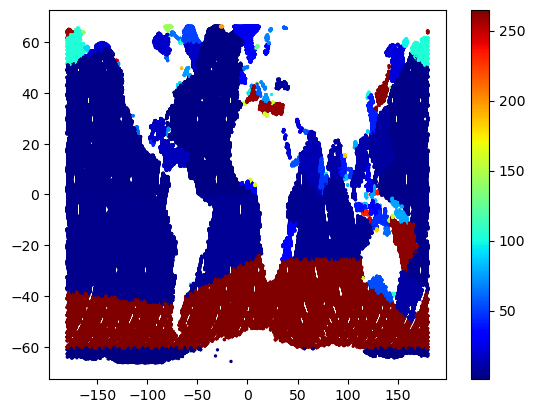

In [10]:
#sanity check: compare bflag and basin mask map
#bflag
plt.scatter(lon,lat,2,bflag,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

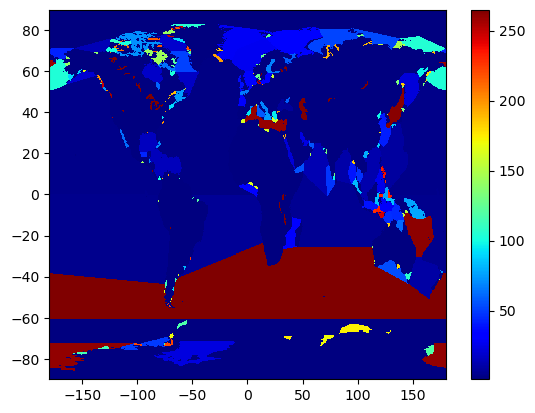

In [11]:
#basin mask map
plt.pcolor(longrid,latgrid,bmask,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

In [12]:
# make grid

# make map 1 piece at a time, basin by basin
tmpmap=np.zeros(np.shape(LOgrid))*np.nan
counts=np.zeros(np.shape(LOgrid))*np.nan
starttime=time.time()
for i in range(len(fid)):
    # get grid points for this basin number
    ll=np.where(bmask==fid[i])
    if np.shape(ll)[1]>0:
        ii=np.where((np.isfinite(ssh)&np.isin(bflag,flist[i])))[0]
        if len(ii)>nb:
            # make a "swath" for this set of output grid points
            grid_def=geometry.SwathDefinition(lons=LOgrid[ll],lats=LAgrid[ll])
            # make a "swath" for this set of along track data
            alongtrack_def=geometry.SwathDefinition(lons=lon[ii], lats=lat[ii])
            # use pyresample to do gridding
            [tmpmap[ll], _, counts[ll]]=kd_tree.resample_gauss(alongtrack_def,ssh[ii],grid_def,roi,sigmas=sig,neighbours=nb,with_uncert=True,fill_value=np.nan)

print('Runtime Segmented Grid: ',time.time()-starttime)

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 500 neighbours within 600000.0 m for some data points
  get_neighbour_info(source_geo_def,


Runtime Segmented Grid:  12.312774658203125


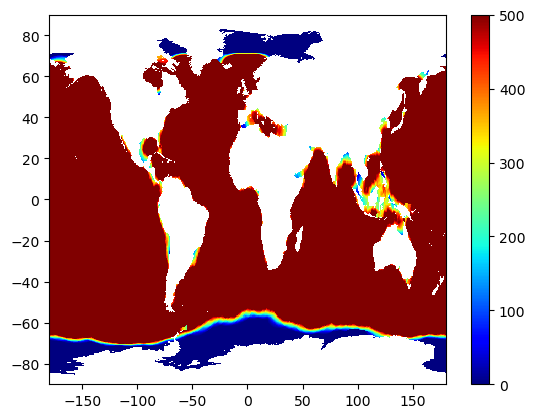

In [13]:
plt.pcolormesh(longrid,latgrid,counts,cmap='jet')
plt.colorbar()

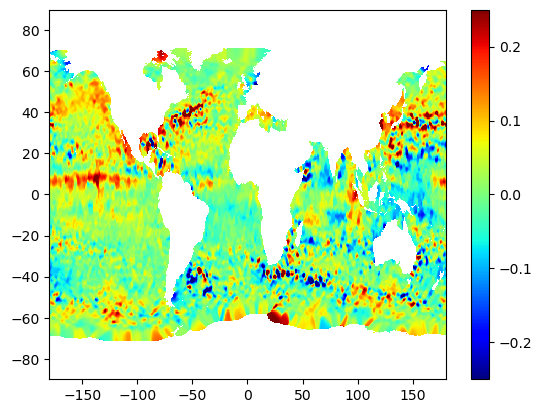

In [14]:
plt.pcolormesh(longrid,latgrid,tmpmap,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

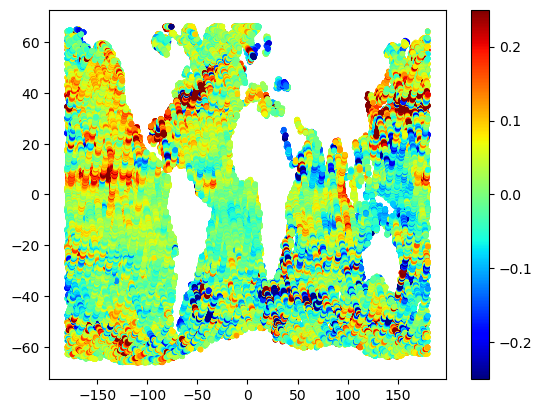

In [15]:
plt.scatter(lon,lat,8,ssh,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

# Make grids from ECCO synthetic along track data

### No error

In [7]:
# get filenames in that directory
files = sorted(glob.glob(os.path.join(at_file_dir, '*.nc')))
files[0]

'/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23.nc'

In [15]:
j=0
time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)

import myDate
[year,month,day]=myDate.jj2date(time_fiction[j+4])
fileout=str(grids_file_dir) + '/SSHA_gridded_'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'.nc'
print('creating grid '+fileout)

lat=[]
lon=[]
ssh=[]
for i in range(0,10):
    [year,month,day]=myDate.jj2date(time_fiction[j+i])
    if len(glob.glob(os.path.join(at_file_dir, 'ECCO_V4r4_alongtrack_SSH_'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'*.nc')))>0:
        file=glob.glob(os.path.join(at_file_dir, 'ECCO_V4r4_alongtrack_SSH_'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'*.nc'))[0]
        xds = xr.open_dataset(file)     
        lon=np.concatenate((lon,np.array(xds['lon'])))
        lat=np.concatenate((lat,np.array(xds['lat'])))
        ssh=np.concatenate((ssh,np.array(xds['SSH_at_xy'])))
    else:
        print('no file on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))


creating grid /home/jpluser/ECCO_GMSL/Data/gridding_output_nosicapplied/SSHA_gridded_1992-09-27.nc


0

In [17]:
# load along-track data into arrays for the 10 first days
xds = xr.open_mfdataset(
        paths=files[0:10],
        combine='nested',
        concat_dim='i') 
                    
# make "running" arrays, keep several days of data loaded at once
lon=np.array(xds['lon'])
lat=np.array(xds['lat'])
ssh=np.array(xds['SSH_at_xy'])

# change longitudes to +/- 180
ii=np.where(lon>180)
lon[ii]=lon[ii]-360

In [18]:
# create bflag that tells us which basin is in each ssh alongtrack (interpolation of swath on basin grid)
lon,lat = utils.check_and_wrap(lon,lat)
ssh_swath_def = geometry.SwathDefinition(lons=lon, lats=lat)

bflag=kd_tree.resample_nearest(bmask_grid_def,bmask,ssh_swath_def,radius_of_influence=200000,fill_value = 0)

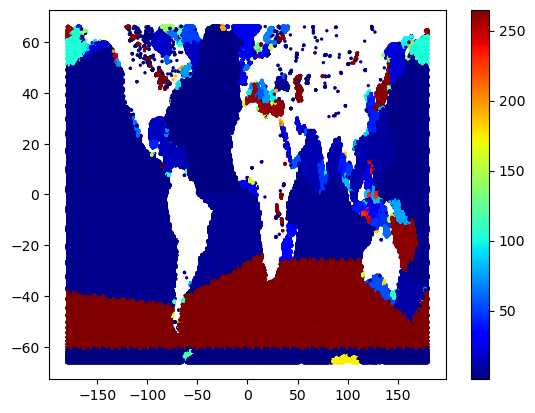

In [19]:
#sanity check: compare bflag and basin mask map
#bflag
plt.scatter(lon,lat,2,bflag,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

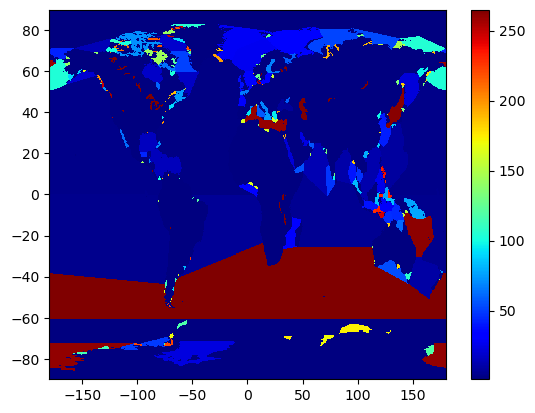

In [20]:
#basin mask map
plt.pcolor(longrid,latgrid,bmask,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

In [21]:
# make grid

# make map 1 piece at a time, basin by basin
tmpmap=np.zeros(np.shape(LOgrid))*np.nan
starttime=time.time()
for i in range(len(fid)):
    # get grid points for this basin number
    ll=np.where(bmask==fid[i])
    if np.shape(ll)[1]>0:
        ii=np.where((np.isfinite(ssh)&np.isin(bflag,flist[i])))[0]
        if len(ii)>nb:
            # make a "swath" for this set of output grid points
            grid_def=geometry.SwathDefinition(lons=LOgrid[ll],lats=LAgrid[ll])
            # make a "swath" for this set of along track data
            alongtrack_def=geometry.SwathDefinition(lons=lon[ii], lats=lat[ii])
            # use pyresample to do gridding
            tmpmap[ll]=kd_tree.resample_gauss(alongtrack_def,ssh[ii],grid_def,roi,sigmas=sig,neighbours=nb,fill_value=np.nan)

print('Runtime Segmented Grid: ',time.time()-starttime)

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 500 neighbours within 600000.0 m for some data points
  get_neighbour_info(source_geo_def,


Runtime Segmented Grid:  10.393747329711914


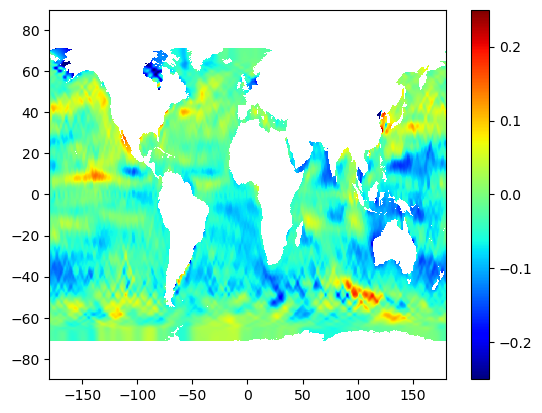

In [22]:
plt.pcolormesh(longrid,latgrid,tmpmap,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

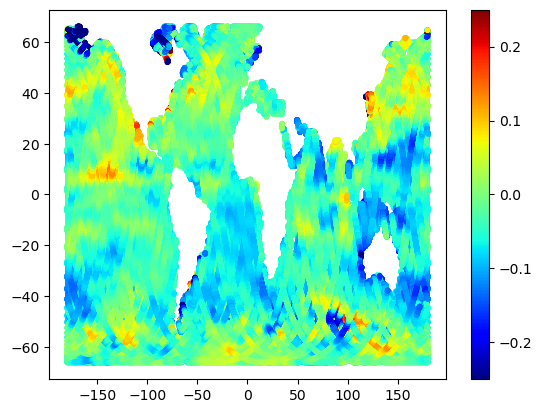

In [23]:
plt.scatter(lon,lat,8,ssh,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

### Random Noise

In [24]:
# get filenames in that directory
files = sorted(glob.glob(os.path.join(at_file_dir_randomnoise, '*.nc')))

In [25]:
# load along-track data into arrays for the 10 first days
xds = xr.open_mfdataset(
        paths=files[0:10],
        combine='nested',
        concat_dim='i') 
                    
# make "running" arrays, keep several days of data loaded at once
lon=np.array(xds['lon'])
lat=np.array(xds['lat'])
ssh=np.array(xds['SSH_at_xy'])

# change longitudes to +/- 180
ii=np.where(lon>180)
lon[ii]=lon[ii]-360

In [26]:
# create bflag that tells us which basin is in each ssh alongtrack (interpolation of swath on basin grid)
lon,lat = utils.check_and_wrap(lon,lat)
ssh_swath_def = geometry.SwathDefinition(lons=lon, lats=lat)

bflag=kd_tree.resample_nearest(bmask_grid_def,bmask,ssh_swath_def,radius_of_influence=200000,fill_value = 0)

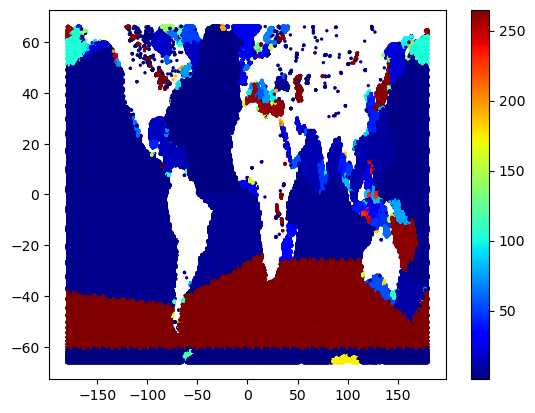

In [27]:
#sanity check: compare bflag and basin mask map
#bflag
plt.scatter(lon,lat,2,bflag,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

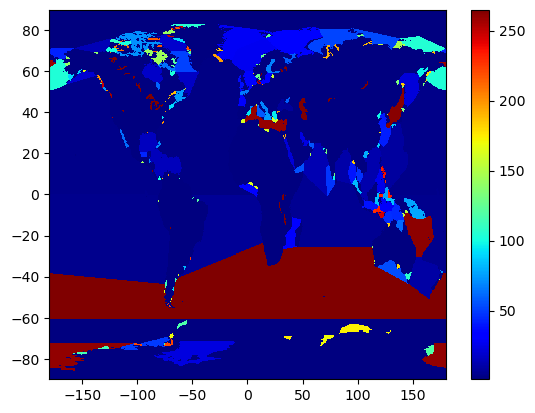

In [28]:
#basin mask map
plt.pcolor(longrid,latgrid,bmask,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

In [29]:
# make grid

# make map 1 piece at a time, basin by basin
tmpmap=np.zeros(np.shape(LOgrid))*np.nan
starttime=time.time()
for i in range(len(fid)):
    # get grid points for this basin number
    ll=np.where(bmask==fid[i])
    if np.shape(ll)[1]>0:
        ii=np.where((np.isfinite(ssh)&np.isin(bflag,flist[i])))[0]
        if len(ii)>nb:
            # make a "swath" for this set of output grid points
            grid_def=geometry.SwathDefinition(lons=LOgrid[ll],lats=LAgrid[ll])
            # make a "swath" for this set of along track data
            alongtrack_def=geometry.SwathDefinition(lons=lon[ii], lats=lat[ii])
            # use pyresample to do gridding
            tmpmap[ll]=kd_tree.resample_gauss(alongtrack_def,ssh[ii],grid_def,roi,sigmas=sig,neighbours=nb,fill_value=np.nan)

print('Runtime Segmented Grid: ',time.time()-starttime)

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 500 neighbours within 600000.0 m for some data points
  get_neighbour_info(source_geo_def,


Runtime Segmented Grid:  13.375446557998657


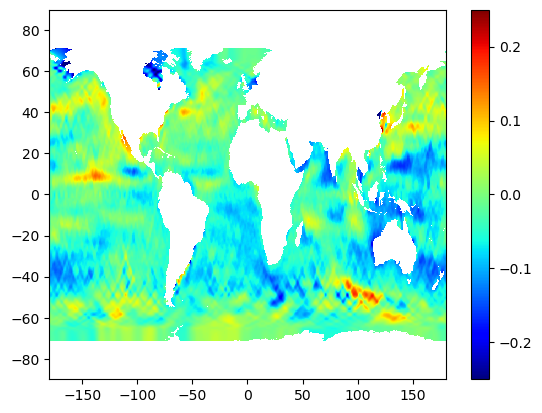

In [30]:
plt.pcolormesh(longrid,latgrid,tmpmap,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

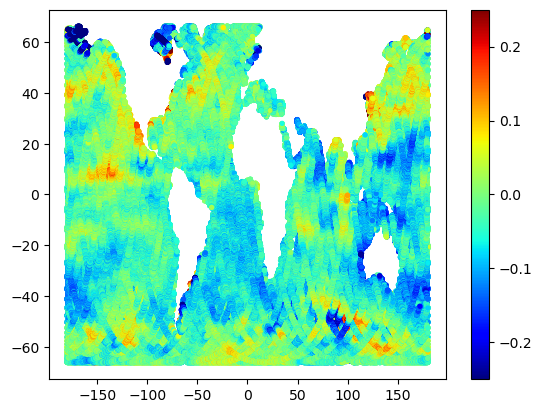

In [31]:
plt.scatter(lon,lat,8,ssh,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

### Missing Data

In [32]:
# get filenames in that directory
files = sorted(glob.glob(os.path.join(at_file_dir_missingdata, '*.nc')))

In [34]:
# load along-track data into arrays for the 10 first days
xds = xr.open_mfdataset(
        paths=files[0:10],
        combine='nested',
        concat_dim='i') 
                    
# make "running" arrays, keep several days of data loaded at once
lon=np.array(xds['lon'])
lat=np.array(xds['lat'])
ssh=np.array(xds['SSH_at_xy'])

# change longitudes to +/- 180
ii=np.where(lon>180)
lon[ii]=lon[ii]-360

In [35]:
# create bflag that tells us which basin is in each ssh alongtrack (interpolation of swath on basin grid)
lon,lat = utils.check_and_wrap(lon,lat)
ssh_swath_def = geometry.SwathDefinition(lons=lon, lats=lat)

bflag=kd_tree.resample_nearest(bmask_grid_def,bmask,ssh_swath_def,radius_of_influence=200000,fill_value = 0)

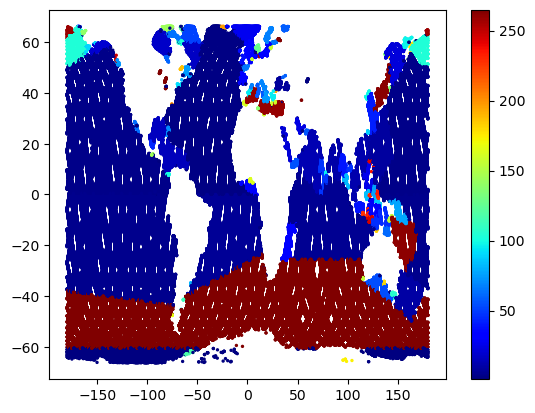

In [36]:
#sanity check: compare bflag and basin mask map
#bflag
plt.scatter(lon,lat,2,bflag,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

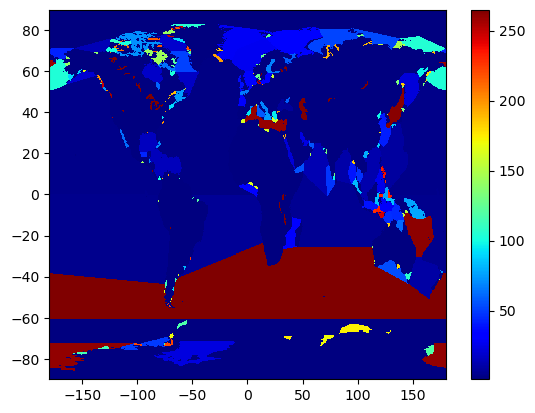

In [37]:
#basin mask map
plt.pcolor(longrid,latgrid,bmask,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

In [38]:
# make grid

# make map 1 piece at a time, basin by basin
tmpmap=np.zeros(np.shape(LOgrid))*np.nan
starttime=time.time()
for i in range(len(fid)):
    # get grid points for this basin number
    ll=np.where(bmask==fid[i])
    if np.shape(ll)[1]>0:
        ii=np.where((np.isfinite(ssh)&np.isin(bflag,flist[i])))[0]
        if len(ii)>nb:
            # make a "swath" for this set of output grid points
            grid_def=geometry.SwathDefinition(lons=LOgrid[ll],lats=LAgrid[ll])
            # make a "swath" for this set of along track data
            alongtrack_def=geometry.SwathDefinition(lons=lon[ii], lats=lat[ii])
            # use pyresample to do gridding
            tmpmap[ll]=kd_tree.resample_gauss(alongtrack_def,ssh[ii],grid_def,roi,sigmas=sig,neighbours=nb,fill_value=np.nan)

print('Runtime Segmented Grid: ',time.time()-starttime)

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 500 neighbours within 600000.0 m for some data points
  get_neighbour_info(source_geo_def,


Runtime Segmented Grid:  11.686152458190918


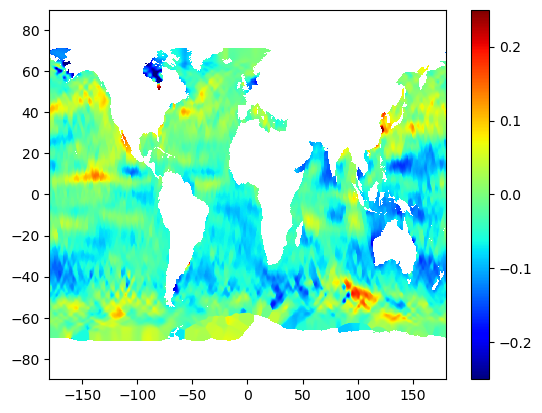

In [39]:
plt.pcolormesh(longrid,latgrid,tmpmap,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

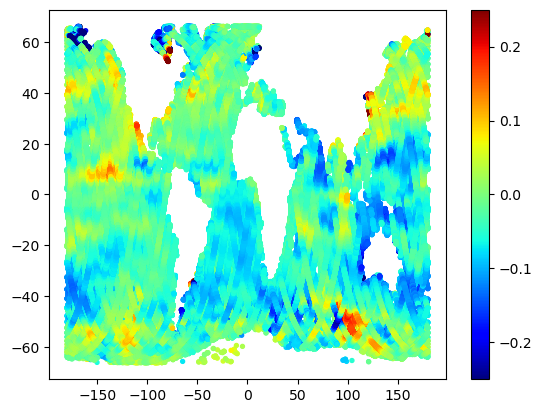

In [40]:
plt.scatter(lon,lat,8,ssh,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

### Orbit error - 2cm

In [41]:
# get filenames in that directory
files = sorted(glob.glob(os.path.join(at_file_dir_orbiterror_2cm, '*.nc')))

In [42]:
# load along-track data into arrays for the 10 first days
xds = xr.open_mfdataset(
        paths=files[0:10],
        combine='nested',
        concat_dim='i') 
                    
# make "running" arrays, keep several days of data loaded at once
lon=np.array(xds['lon'])
lat=np.array(xds['lat'])
ssh=np.array(xds['SSH_at_xy'])

# change longitudes to +/- 180
ii=np.where(lon>180)
lon[ii]=lon[ii]-360

In [43]:
# create bflag that tells us which basin is in each ssh alongtrack (interpolation of swath on basin grid)
lon,lat = utils.check_and_wrap(lon,lat)
ssh_swath_def = geometry.SwathDefinition(lons=lon, lats=lat)

bflag=kd_tree.resample_nearest(bmask_grid_def,bmask,ssh_swath_def,radius_of_influence=200000,fill_value = 0)

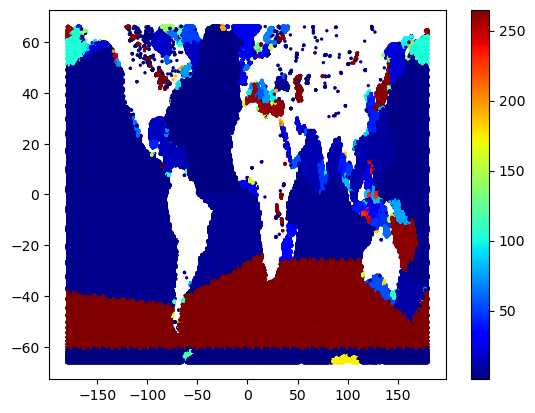

In [44]:
#sanity check: compare bflag and basin mask map
#bflag
plt.scatter(lon,lat,2,bflag,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

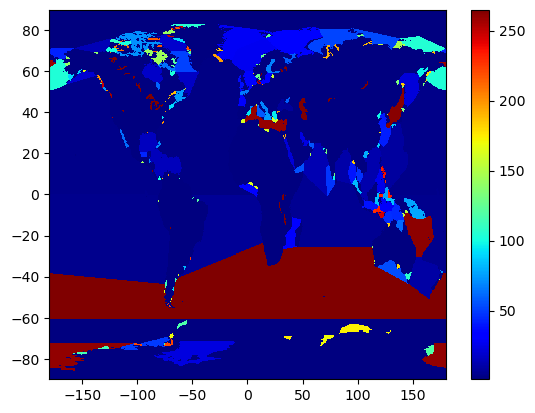

In [45]:
#basin mask map
plt.pcolor(longrid,latgrid,bmask,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

In [46]:
# make grid

# make map 1 piece at a time, basin by basin
tmpmap=np.zeros(np.shape(LOgrid))*np.nan
starttime=time.time()
for i in range(len(fid)):
    # get grid points for this basin number
    ll=np.where(bmask==fid[i])
    if np.shape(ll)[1]>0:
        ii=np.where((np.isfinite(ssh)&np.isin(bflag,flist[i])))[0]
        if len(ii)>nb:
            # make a "swath" for this set of output grid points
            grid_def=geometry.SwathDefinition(lons=LOgrid[ll],lats=LAgrid[ll])
            # make a "swath" for this set of along track data
            alongtrack_def=geometry.SwathDefinition(lons=lon[ii], lats=lat[ii])
            # use pyresample to do gridding
            tmpmap[ll]=kd_tree.resample_gauss(alongtrack_def,ssh[ii],grid_def,roi,sigmas=sig,neighbours=nb,fill_value=np.nan)

print('Runtime Segmented Grid: ',time.time()-starttime)

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 500 neighbours within 600000.0 m for some data points
  get_neighbour_info(source_geo_def,


Runtime Segmented Grid:  13.557759523391724


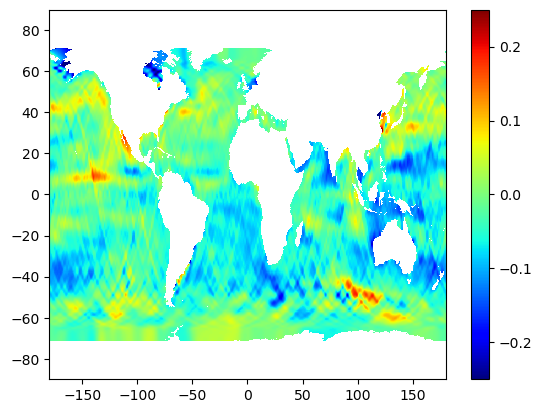

In [47]:
plt.pcolormesh(longrid,latgrid,tmpmap,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

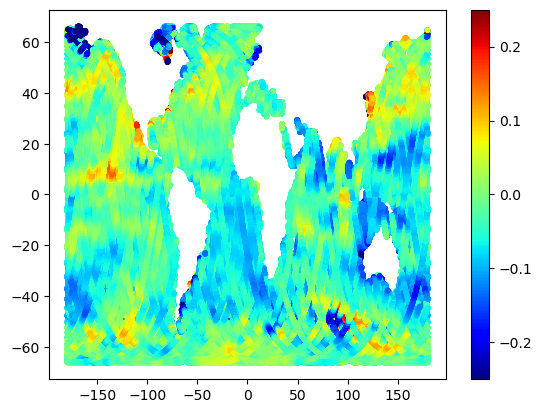

In [48]:
plt.scatter(lon,lat,8,ssh,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

### 3 errors: random noise + missing data + orbit error - 2cm

In [49]:
# get filenames in that directory
files = sorted(glob.glob(os.path.join(at_file_dir_3errors_2cm, '*.nc')))

In [50]:
# load along-track data into arrays for the 10 first days
xds = xr.open_mfdataset(
        paths=files[0:10],
        combine='nested',
        concat_dim='i') 
                    
# make "running" arrays, keep several days of data loaded at once
lon=np.array(xds['lon'])
lat=np.array(xds['lat'])
ssh=np.array(xds['SSH_at_xy'])

# change longitudes to +/- 180
ii=np.where(lon>180)
lon[ii]=lon[ii]-360

In [51]:
# create bflag that tells us which basin is in each ssh alongtrack (interpolation of swath on basin grid)
lon,lat = utils.check_and_wrap(lon,lat)
ssh_swath_def = geometry.SwathDefinition(lons=lon, lats=lat)

bflag=kd_tree.resample_nearest(bmask_grid_def,bmask,ssh_swath_def,radius_of_influence=200000,fill_value = 0)

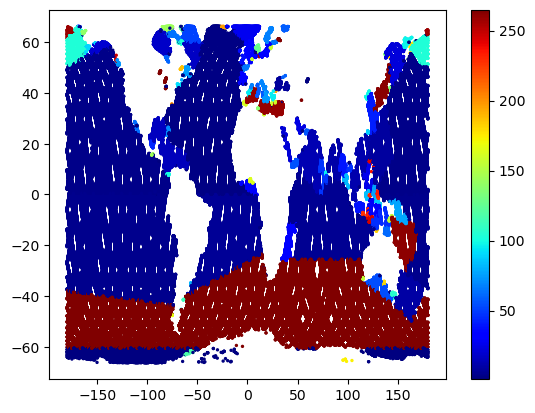

In [52]:
#sanity check: compare bflag and basin mask map
#bflag
plt.scatter(lon,lat,2,bflag,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

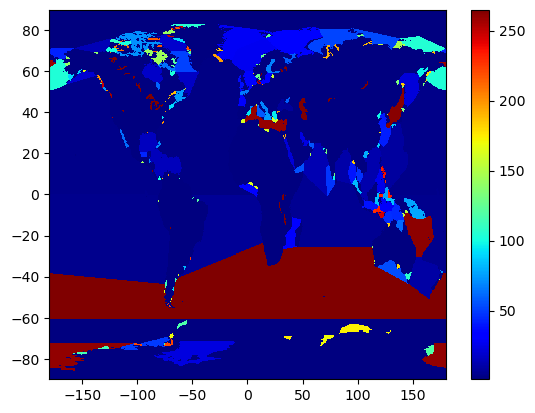

In [53]:
#basin mask map
plt.pcolor(longrid,latgrid,bmask,cmap='jet',vmin=1,vmax=265)
plt.colorbar()

In [54]:
# make grid

# make map 1 piece at a time, basin by basin
tmpmap=np.zeros(np.shape(LOgrid))*np.nan
starttime=time.time()
for i in range(len(fid)):
    # get grid points for this basin number
    ll=np.where(bmask==fid[i])
    if np.shape(ll)[1]>0:
        ii=np.where((np.isfinite(ssh)&np.isin(bflag,flist[i])))[0]
        if len(ii)>nb:
            # make a "swath" for this set of output grid points
            grid_def=geometry.SwathDefinition(lons=LOgrid[ll],lats=LAgrid[ll])
            # make a "swath" for this set of along track data
            alongtrack_def=geometry.SwathDefinition(lons=lon[ii], lats=lat[ii])
            # use pyresample to do gridding
            tmpmap[ll]=kd_tree.resample_gauss(alongtrack_def,ssh[ii],grid_def,roi,sigmas=sig,neighbours=nb,fill_value=np.nan)

print('Runtime Segmented Grid: ',time.time()-starttime)

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 500 neighbours within 600000.0 m for some data points
  get_neighbour_info(source_geo_def,


Runtime Segmented Grid:  11.9509117603302


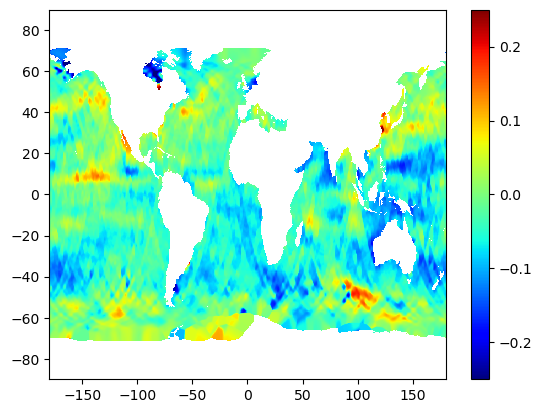

In [55]:
plt.pcolormesh(longrid,latgrid,tmpmap,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()

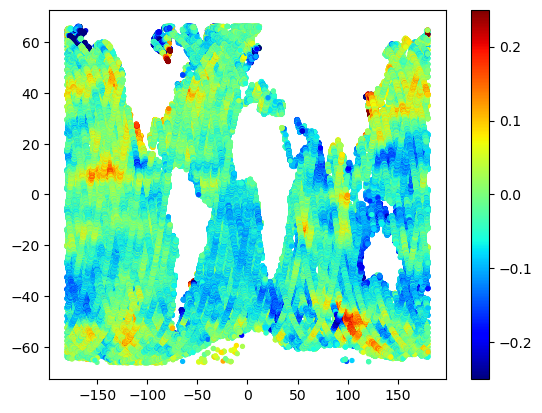

In [56]:
plt.scatter(lon,lat,8,ssh,cmap='jet',vmin=-.25,vmax=.25)
plt.colorbar()